## Hyperparameter Tuning RF Test 81 & 82

### Import library

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time

### Pra proses
from sklearn.preprocessing import MinMaxScaler

### Near Miss under sampling
from imblearn.under_sampling import NearMiss 

### Bagi data
from sklearn.model_selection import train_test_split

### Seleksi fitur
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Random forest (RF)
from sklearn.ensemble import RandomForestClassifier

### metrik pengukuran
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import make_scorer, f1_score

### Tuning Hyperparameter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

### save model
import joblib

import warnings
warnings.filterwarnings('ignore')

# menampilkan lebih banyak kolom dan baris pada Dataset
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Tipe Dataset #
# ============ #

tipe_dataset = {'dst_port':'uint32','protocol':'uint8','timestamp':'uint64','flow_duration':'int64','tot_fwd_pkts':'uint32','tot_bwd_pkts':'uint32','totlen_fwd_pkts':'uint32','totlen_bwd_pkts':'uint32','fwd_pkt_len_max':'uint16','fwd_pkt_len_min':'uint16',
'fwd_pkt_len_mean':'float32','fwd_pkt_len_std':'float32','bwd_pkt_len_max':'uint16','bwd_pkt_len_min':'uint16','bwd_pkt_len_mean':'float32','bwd_pkt_len_std':'float32','flow_byts_s':'float64','flow_pkts_s':'float64','flow_iat_mean':'float32','flow_iat_std':'float32',
'flow_iat_max':'int64','flow_iat_min':'int64','fwd_iat_tot':'int64','fwd_iat_mean':'float32','fwd_iat_std':'float32','fwd_iat_max':'int64','fwd_iat_min':'int64','bwd_iat_tot':'uint32','bwd_iat_mean':'float32','bwd_iat_std':'float32',
'bwd_iat_max':'uint32','bwd_iat_min':'uint32','fwd_psh_flags':'uint8','bwd_psh_flags':'uint8','fwd_urg_flags':'uint8','bwd_urg_flags':'uint8','fwd_header_len':'uint32','bwd_header_len':'uint32','fwd_pkts_s':'float32','bwd_pkts_s':'float32',
'pkt_len_min':'uint16','pkt_len_max':'uint16','pkt_len_mean':'float32','pkt_len_std':'float32','pkt_len_var':'float32','fin_flag_cnt':'uint8','syn_flag_cnt':'uint8','rst_flag_cnt':'uint8','psh_flag_cnt':'uint8','ack_flag_cnt':'uint8',
'urg_flag_cnt':'uint8','cwe_flag_count':'uint8','ece_flag_cnt':'uint8','down_up_ratio':'uint16','pkt_size_avg':'float32','fwd_seg_size_avg':'float32','bwd_seg_size_avg':'float32','fwd_byts_b_avg':'uint8','fwd_pkts_b_avg':'uint8','fwd_blk_rate_avg':'uint8',
'bwd_byts_b_avg':'uint8','bwd_pkts_b_avg':'uint8','bwd_blk_rate_avg':'uint8','subflow_fwd_pkts':'uint32','subflow_fwd_byts':'uint32','subflow_bwd_pkts':'uint32','subflow_bwd_byts':'uint32','init_fwd_win_byts':'int32','init_bwd_win_byts':'int32','fwd_act_data_pkts':'uint32',
'fwd_seg_size_min':'uint8','active_mean':'float32','active_std':'float32','active_max':'uint32','active_min':'uint32','idle_mean':'float32','idle_std':'float32','idle_max':'uint64','idle_min':'uint64','label':'category',
'flow_id':'object','src_ip':'object','src_port':'float64','dst_ip':'object'}

In [3]:
# Fungsi #
# ====== #

# bagi dataset menjadi variabel input X dan variabel output y
def variabel_input_output(dataset, n, variabel_output):
    X = dataset.iloc[:,:-n]
    y = dataset[variabel_output]
    return X, y

# seleksi fitur metode Chi-squared
def seleksi_fitur(metode, X, y):
    chi2 = SelectKBest(score_func= metode , k=X.shape[1])
    fit = chi2.fit(X, y) 
    return fit

# pemilihan fitur terbaik
def fitur_terbaik(klf, persentase_skor, X, tipe):
    if tipe == 'rf' :
        importances = klf.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]
        labels = X.columns
    
        # mengurutkan fitur berdasarkan skor tertinggi
        skor_fitur = zip(labels, importances)
        skor_fitur_diurutkan = sorted(skor_fitur, key = lambda x: x[1], reverse = True)
        skor_diurutkan = [skor[1] for skor in skor_fitur_diurutkan]
        fitur_diurutkan = [skor[0] for skor in skor_fitur_diurutkan]

        # Fitur dengan persentase skor 1% atau 5% dihapus
        # pilih fitur dengan persentase skor 95% atau 99%
        fitur_skor_rendah = []
        total_skor = 0 
        jumlah_persentase = []
        for skor in skor_fitur_diurutkan:
            total_skor = total_skor + skor[1]
            jumlah_persentase.append(total_skor)
            if total_skor >= sum(skor_diurutkan)*(persentase_skor/100):
                fitur_skor_rendah.append(skor[0])
                 
        # menampilkan fitur terpilih dengan persentase skor 95% atau 99%
        fitur_terpilih = pd.DataFrame({'Fitur':fitur_diurutkan, 
                                       'Persentase skor': skor_diurutkan/sum(importances)*100,
                                       'jumlah persentase': jumlah_persentase/sum(importances)*100})
        fitur_terpilih.index = np.arange(1,len(fitur_terpilih)+1)                                        
        fitur_terpilih = fitur_terpilih[~fitur_terpilih['Fitur'].isin(fitur_skor_rendah)]
    
        # plot skor dengan setiap fitur
        plt.figure(figsize=(11, 5))
        plt.title('Bobot Fitur')
        plt.bar([i for i in range(len(importances))], importances)
        plt.xticks([i for i in range(len(importances))], X.columns)
        plt.xticks(rotation=80, fontsize=10)
        plt.tight_layout()
        #plt.savefig('features.png', dpi=300)
        
    else :
        # mengurutkan fitur berdasarkan bobot tertinggi
        skor_fitur = zip(X.columns, klf.scores_)
        skor_fitur_diurutkan = sorted(skor_fitur, key = lambda x: x[1], reverse = True)
        skor_diurutkan = [skor[1] for skor in skor_fitur_diurutkan]
        fitur_diurutkan = [skor[0] for skor in skor_fitur_diurutkan]
    
        # Fitur dengan persentase skor 1% atau 5% dihapus
        # pilih fitur dengan persentase skor 95% atau 99%
        fitur_skor_rendah = []
        total_skor = 0 
        jumlah_persentase = []
        for skor in skor_fitur_diurutkan:
            total_skor = total_skor + skor[1]
            jumlah_persentase.append(total_skor)
            if total_skor >= sum(skor_diurutkan)*(persentase_skor/100):
                fitur_skor_rendah.append(skor[0])
  
        # menampilkan fitur terpilih dengan persentase skor 95% atau 99%
        fitur_terpilih = pd.DataFrame({'Skor Chi-kuadrat':skor_diurutkan, 'Fitur':fitur_diurutkan, 
                                       'Persentase skor': skor_diurutkan/sum(klf.scores_)*100,
                                       'jumlah persentase': jumlah_persentase/sum(klf.scores_)*100})
        fitur_terpilih.index = np.arange(1,len(fitur_terpilih)+1)
        fitur_terpilih = fitur_terpilih[~fitur_terpilih['Fitur'].isin(fitur_skor_rendah)]
    
        # plot skor dengan setiap fitur
        plt.figure(figsize=(11, 5))
        plt.title('Bobot Fitur')
        plt.bar([i for i in range(len(klf.scores_))], klf.scores_)
        plt.xticks([i for i in range(len(klf.scores_))], X.columns)
        plt.xticks(rotation=80, fontsize=10)
        plt.tight_layout()
        #plt.savefig('features.png', dpi=300)
    
    # skor kumulatif
    skor_kumulatif = np.cumsum(skor_diurutkan)
    plt.figure(figsize=(13,5))
    x_values = range(len(skor_fitur_diurutkan))
    plt.plot(x_values, skor_kumulatif)

    # menampilkan garis batas persentase skor
    garis_batas = skor_kumulatif[-1]*(persentase_skor/100)
    plt.hlines(y = garis_batas, xmin=0, xmax=len(skor_diurutkan), color = 'r', linestyles = 'dashed')
    plt.xticks(x_values, fitur_diurutkan, rotation = 80, fontsize=10)
    plt.yticks([], [])
    plt.xlabel('Fitur', fontsize=12)
    plt.title('Skor Fitur', fontsize=12)
    plt.tight_layout()
    #plt.savefig('cum_features.png', dpi=300)
    print ("Fitur yang dihapus")
    print ('==================')
    print(fitur_skor_rendah)
    print ('\n')
    print ('Fitur dengan skor terbaik')
    print ('=========================')
    print (fitur_terpilih)
    
    return fitur_skor_rendah, fitur_terpilih

# misklasifikasi
def misklasifikasi(y_aktual, y_prediksi):
    print('misklasifikasi kelas target:')
    print('============================')
    
    misklasifikasi = y_aktual[y_aktual != y_prediksi]

    mk_df = pd.merge(pd.DataFrame({'misklasifikasi': misklasifikasi.value_counts()}),
                     pd.DataFrame({'total': y_aktual.value_counts()}),
                     how='left', left_index=True, right_index=True)
    mk_df['persentase_misklasifikasi(%)'] = mk_df.apply(lambda x: x[0] / x[1], axis=1)*100
    print (mk_df.sort_values('persentase_misklasifikasi(%)', ascending=False))

# metrik evaluasi
def metrik(clf, figsize, y_aktual, y_prediksi):
    print('')
    print('Accuracy, Precision, Recall dan F1-score :')
    print('==========================================')
    accuracy = accuracy_score(y_aktual, y_prediksi) 
    precision_rfc, recall_rfc, fscore_rfc, none = score(y_aktual, y_prediksi, average='macro')    
    print('Accuracy  : '+(str(accuracy)))
    print('Precision : '+(str(precision_rfc)))
    print('Recall    : '+(str(recall_rfc)))
    print('F1-score  : '+(str(fscore_rfc)))
        
    print('')
    print('metrik evaluasi :')
    print('=================')
    print(classification_report(y_aktual, y_prediksi, digits=6))
    
    print('')
    print('matriks "confusion" :')
    print('=====================')
    f,ax = plt.subplots(figsize=(7.5*figsize,5*figsize))
    cm = confusion_matrix(y_aktual, y_prediksi)
    if figsize == 1 :
        #if clf == None :
            #group_names = ['True Neg','False Pos','False Neg','True Pos']
        
        #else :
            #group_names = ['True','False','False ','True ']
            #group_names = ['True Pos','False Neg','False Pos','True Neg']
        
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in (cm/np.sum(cm,axis=1)).flatten()]
        #labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        ax = sns.heatmap(cm, annot=labels, linewidth=3, linecolor="black", fmt='', cmap='Blues')
    
    else :
        ax = sns.heatmap(cm, annot=True, linewidth=3, linecolor="black", fmt=".0f", cmap='Greens')
        
    ax.set_xlabel('Label Prediksi', fontsize=12)
    ax.set_ylabel('Label Aktual', fontsize=12)
    ax.set_title('matriks "confusion"')

    if clf == None:
        Label = None
        plt.yticks(rotation=0, ha="right")
        plt.show() 
    else :
        Label = clf.classes_
        #if len(Label) < 15:
            #Label = Label
            #Label = np.append(['benign'],Label)
        #else :
            #Label = Label  
        ax.xaxis.set_ticklabels(Label)
        ax.yaxis.set_ticklabels(Label)
        plt.yticks(rotation=0, ha="right")
        plt.xticks(rotation=40, ha="right")
        plt.show() 
        
def param_terbaik_ke(param_ke):
    print ('Hyperparameter ke 1')
    print ('===================')
    return [param_rf[param_ke-1]]

def latih_eval_rf (params, jlh_est, y_aktual):
    global param_ke,hasil_akurasi,hasil_p_macro,hasil_p_weight,hasil_r_macro,hasil_r_weight,hasil_f1_macro,hasil_f1_weight,hasil_waktu_latih, hasil_waktu_pred,jumlah_estimator,hasil_y_pred
    hasil_akurasi=[]; hasil_p_macro=[]; hasil_p_weight=[]
    hasil_r_macro=[]; hasil_r_weight=[]; hasil_f1_macro=[]
    hasil_f1_weight=[]; hasil_waktu_latih=[]; hasil_waktu_pred=[];
    jumlah_estimator=[];hasil_y_pred=[]
      
    for m in jlh_est: 
        if len(jlh_est) > 1 : 
            print("jumlah 'trees' :",m)
            print('===================')
        param_ke = 0
        for n in params:
            # fit model dengan parameter jlh_estimator 
            param_ke += 1
            if len(params) > 1 :
                print('hyperparameter ke 1')
                print('===================')
            print('hyperparameter :',n)
            m_latih = time.time()
            if len(jlh_est) > 1 :
                klasifikasi = RandomForestClassifier(**n, n_estimators= m)
            else:
                klasifikasi = RandomForestClassifier(**n, random_state=42, n_jobs=-1)
            klasifikasi.fit(X_train_chi, y_train['label'])
            s_latih = time.time()
            waktu_latih = s_latih-m_latih
            print ('Lama waktu latih    :', waktu_latih)
    
            # prediksi
            m_pred = time.time()
            y_pred = klasifikasi.predict(X_test_chi)
            s_pred = time.time()
            print ('Lama waktu prediksi :', s_pred-m_pred)
    
            # metrik evaluasi
            akurasi = accuracy_score(y_aktual, y_pred)
            p_macro,r_macro,f1_macro,n = score(y_aktual, y_pred, average='macro')
            p_weight,r_weight,f1_weight,n = score(y_aktual, y_pred, average='weighted')
    
            # tambahkan hasil
            hasil_akurasi.append(akurasi); hasil_p_macro.append(p_macro); hasil_p_weight.append(p_weight)
            hasil_r_macro.append(r_macro); hasil_r_weight.append(r_weight); hasil_f1_macro.append(f1_macro)
            hasil_f1_weight.append(f1_weight); hasil_waktu_latih.append(waktu_latih); hasil_waktu_pred.append(s_pred-m_pred)
            hasil_y_pred.append(y_pred); jumlah_estimator.append(m)
            print ("hasil 'Accuracy'    :", akurasi)
            print ("hasil 'f1-score'    :", f1_macro)
            print ('')
    param_ke=[i+1 for i in range(len(hasil_akurasi))]
    
    return klasifikasi, y_pred

def plot_eval(hasil_1, hasil_2, jlh_estimator, xlabel, ylabel1, ylabel2):
    print("") 
    pjg = len(ylabel1)+7
    print(' PLOT '+ylabel1.upper())
    print("".center(pjg, '='))    
    hasil_2 = np.around(np.array(hasil_2),8)
    
    if hasil_1 == None :
        fig,ax = plt.subplots(figsize=(15,7))
        ax.bar(jlh_estimator, hasil_2, width=2, label = ylabel1)
               #marker='o',linestyle='dashed', markersize=10, 
               #markerfacecolor = 'b', color='orange', label = ylabel1) 
                
        # batas tampilan sumbu y
        y1 = hasil_2
        y2 = (max(y1)-min(y1))
        ymax = max(y1)+(y2*10/100)
        ymin = min(y1)-(y2*10/100)
        ax.set_ylim([ymin,ymax])
        
        ax.set_xlabel(xlabel,fontsize=12)
        ax.set_ylabel(ylabel1, fontsize=12,)
        ax.tick_params(labelsize=12)
        ax.grid(linestyle = 'dashdot')
        
        for i,j in zip(jlh_estimator,hasil_2):
            ax.annotate(j,xy=(i,j),ha="right", va="bottom",fontsize=12)
        ax.legend(fontsize = 14,loc='center', bbox_to_anchor=(0.5,1.04))
        xy = pd.DataFrame({xlabel : jlh_estimator, ylabel1 : hasil_2})
        colors = [["orange", "mediumslateblue"]]*len(jlh_estimator)         
        ytabel = ax.table(cellText=xy.values, colLabels=xy.columns, loc=14,colLoc ='center',
                          cellLoc ='center',fontsize=12,visible=True,
                          colWidths =(0.15,0.15),cellColours=colors)
        ytabel.set_fontsize(12)
        ytabel.scale(0.8, 1.5)
        ytabel.set_zorder(100)

    else :
        plot=2
        n_plot = np.arange(plot)
        hasil_1 = np.around(np.array(hasil_1),8)
        fig,ax = plt.subplots(1,plot,figsize=(15,7))      
        colors = [["orange", "mediumslateblue"]]*len(jlh_estimator)
        
        ax[0].plot(jlh_estimator, hasil_1, marker='o',linestyle='dashed', markersize=10, 
                   markerfacecolor = 'mediumslateblue', color='orange', label = ylabel1)
        ax[1].plot(jlh_estimator, hasil_2,  marker='o',linestyle='dashed',markersize=10,
                    markerfacecolor = 'orange', color='mediumslateblue', label = ylabel2)       
   
        for i,j,k in zip(jlh_estimator,hasil_1,hasil_2):
            ax[0].annotate(j,xy=(i,j),ha="right", va="bottom",fontsize=12)
            ax[1].annotate(k,xy=(i,k),ha="left", va="bottom",fontsize=12)
        for n in n_plot:
            #xy = pd.DataFrame({xlabel : jlh_estimator, ylabel1 : locals()[f'hasil_{n+1}']})
            ax[n].set_xlabel(xlabel,fontsize=12)
            #ax[n].set_ylabel(ylabel1, fontsize=12)
            ax[0].set_ylabel(ylabel1, fontsize=12)
            ax[1].set_ylabel(ylabel2, fontsize=12)
            ax[n].grid(linestyle = 'dashdot')
            ax[n].tick_params(labelsize=12)
            #ytabel = ax[n].table(cellText=xy.values, colLabels=xy.columns, loc=6,
            #              colLoc ='center',cellLoc ='center',fontsize=20,visible=True,
            #              colWidths =(0.3,0.3),cellColours=colors)
            #ytabel.set_fontsize(20)
            #ytabel.scale(0.8, 1.5)
            #ytabel.set_zorder(100)
            ax[n].legend(fontsize = 14,loc='center',bbox_to_anchor=(0.5,1.04))
            
    plt.tight_layout()
    plt.show()

### Load dataset

In [4]:
# Load Dataset CIC-IDS2018 #
# ======================== #

m_load = time.time()
dataset_cic2018 = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\CSE_CIC_IDS2018_Praproses.csv", dtype = tipe_dataset)
s_load = time.time()
print ('Lama waktu memuat dataset : ', s_load - m_load)

Lama waktu load dataset :  111.4549343585968


In [5]:
# Rasio kelas normal dan serangan sebelum 'under sampling' #
# ======================================================== #

jlh_target = dataset_cic2018['label'].value_counts()
jlh_normal = jlh_target[0]
jlh_serangan =jlh_target[1:15]
print ("Rasio kelas normal dan serangan sebelum 'under sampling'")
print ('=======================================================')
print(round(jlh_normal/jlh_serangan,2))

Rasio kelas normal dan serangan sebelum 'under sampling'
ddos_attack_hoic                19.18
ddos_attacks_loic_http          22.83
dos_attacks_hulk                28.48
bot                             46.01
ftp_bruteforce                  68.03
ssh_bruteforce                  70.12
infilteration                   83.05
dos_attacks_slowhttptest        94.03
dos_attacks_goldeneye          316.91
dos_attacks_slowloris         1196.95
ddos_attack_loic_udp          7603.74
brute_force__web             22295.71
brute_force__xss             57193.35
sql_injection               151200.82
Name: label, dtype: float64


### Under sampling

In [6]:
# Near Miss under sampling #
# ======================== #

# bagi dataset CIC-IDS2018 menjadi X dan y
X_layer, y_layer = variabel_input_output(dataset_cic2018, 1, ['label'])

# rasio 3:1 kelas normal dan serangan
jlh_sampel = dataset_cic2018['label'].value_counts()
jlh_serangan = sum(jlh_sampel[1:15])
jlh_norm = jlh_serangan*3

# nearmiss under sampling rasio 3:1
m_under = time.time()
nm = NearMiss(version=2, n_jobs = -1, sampling_strategy={'benign' : jlh_norm})
X_layer, y_layer = nm.fit_resample(X_layer,y_layer)
s_under = time.time()
print ("Lama waktu 'under sampling' : ", s_under - m_under)

Lama waktu 'under sampling' :  353.340704202652


# =============================

In [4]:
# Load Dataset CIC-IDS2018 #
# ======================== #

m_load = time.time()
dataset_cic2018 = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\CSE_CIC_IDS2018_Praproses_3_1.csv", dtype = tipe_dataset)
s_load = time.time()
print ('Lama waktu memuat dataset : ', s_load - m_load)

Lama waktu memuat dataset :  60.819443225860596


In [5]:
# bagi dataset CIC-IDS2018 menjadi X dan y
X_layer, y_layer = variabel_input_output(dataset_cic2018, 1, ['label'])

# =============================

In [6]:
# Rasio kelas normal dan serangan setelah 'under sampling' #
# ======================================================== #

jlh_sampel = y_layer.value_counts()
jlh_serangan = sum(jlh_sampel[1:15])
jlh_normal = jlh_sampel[0]
print ("Rasio kelas normal dan serangan setelah 'under sampling'")
print ('========================================================')
print (f'jumlah sampel kelas normal dan serangan = {jlh_normal} : {jlh_serangan}' )
print (f'Rasio kelas normal dan serangan         = {jlh_normal/jlh_serangan} : 1')

Rasio kelas normal dan serangan setelah 'under sampling'
jumlah sampel kelas normal dan serangan = 8233200 : 2744400
Rasio kelas normal dan serangan         = 3.0 : 1


In [7]:
# Rasio kelas normal dan serangan setelah 'under sampling' #
# ======================================================== #

jlh_sampel = y_layer.value_counts()
jlh_normal = jlh_sampel[0]
jlh_serangan =jlh_sampel[1:15]

print ("Rasio kelas normal dan serangan setelah 'under sampling'")
print ('========================================================')
print(round(jlh_normal/jlh_serangan,2))

Rasio kelas normal dan serangan setelah 'under sampling'
label                   
ddos_attack_hoic               12.00
ddos_attacks_loic_http         14.29
dos_attacks_hulk               17.82
bot                            28.79
ftp_bruteforce                 42.58
ssh_bruteforce                 43.89
infilteration                  51.98
dos_attacks_slowhttptest       58.85
dos_attacks_goldeneye         198.35
dos_attacks_slowloris         749.15
ddos_attack_loic_udp         4759.08
brute_force__web            13954.58
brute_force__xss            35796.52
sql_injection               94634.48
dtype: float64


### Bagi data

In [8]:
# Bagi data latih dan uji 80%:20% #
# =============================== #

m_bagi = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, train_size = 0.8, test_size = 0.2, random_state = 42, stratify = y_layer)
s_bagi = time.time()
print ('Lama waktu bagi data : ', s_bagi - m_bagi)

Lama waktu bagi data :  58.32750701904297


### Penambahan label

In [9]:
# Penambahan label #
# ================ #

# konversi tipe data label menjadi 'category'
y_train = y_train.astype('category')
y_test = y_test.astype('category')

# penambahan label pada data latih
y_train = pd.DataFrame(y_train)
y_train['label_binary'] = np.where(y_train['label'] == 'benign', 'benign', 'attack')
y_train['label_binary_code'] = np.where(y_train['label'] == 'benign', 0, 1)

# penambahan label pada data uji
y_test = pd.DataFrame(y_test)
y_test['label_binary'] = np.where(y_test['label'] == 'benign', 'benign', 'attack')
y_test['label_binary_code'] = np.where(y_test['label'] == 'benign', 0, 1)

### Normalisasi

In [10]:
# Normalisasi data #
# ================ #

m_norm = time.time()

# menskalakan nilai setiap fitur ke rentang 0 sampai 1 dengan 'MinMaxscaler'.
scaler = MinMaxScaler().fit(X_train)

# terapkan normalisasi
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm)
X_train_norm.columns = X_train.columns
X_test_norm = pd.DataFrame(X_test_norm)
X_test_norm.columns = X_train.columns

s_norm = time.time()
print ('Lama waktu min-max normalisasi : ', s_norm - m_norm)

Lama waktu min-max normalisasi :  7.601538181304932


# =========================================

## Test 81

### 81.1. Seleksi fitur chi squared - 95%

Fitur yang dihapus
['dst_port', 'flow_iat_std', 'bwd_iat_std', 'fwd_pkt_len_max', 'fwd_psh_flags', 'active_max', 'active_mean', 'fwd_pkt_len_std', 'active_std', 'bwd_pkt_len_std', 'pkt_len_std', 'timestamp', 'fwd_pkt_len_mean', 'active_min', 'bwd_pkt_len_min', 'pkt_len_mean', 'pkt_size_avg', 'bwd_pkt_len_mean', 'fwd_iat_std', 'fwd_urg_flags', 'pkt_len_min', 'fwd_pkt_len_min', 'pkt_len_max', 'bwd_pkt_len_max', 'pkt_len_var', 'fin_flag_cnt', 'bwd_header_len', 'down_up_ratio', 'flow_byts_s', 'tot_bwd_pkts', 'totlen_bwd_pkts']


Fitur dengan skor terbaik
    Skor Chi-kuadrat              Fitur  Persentase skor  jumlah persentase
1       2.409937e+06  fwd_act_data_pkts         7.434345           7.434345
2       2.296485e+06       tot_fwd_pkts         7.084360          14.518704
3       2.215494e+06        flow_pkts_s         6.834514          21.353218
4       1.862728e+06     fwd_header_len         5.746274          27.099492
5       1.811408e+06         bwd_pkts_s         5.587960       

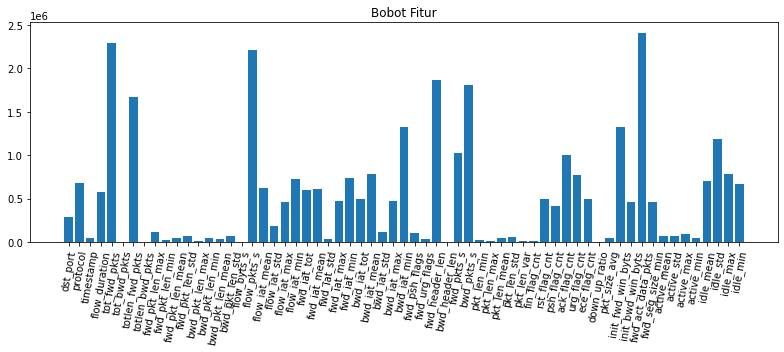

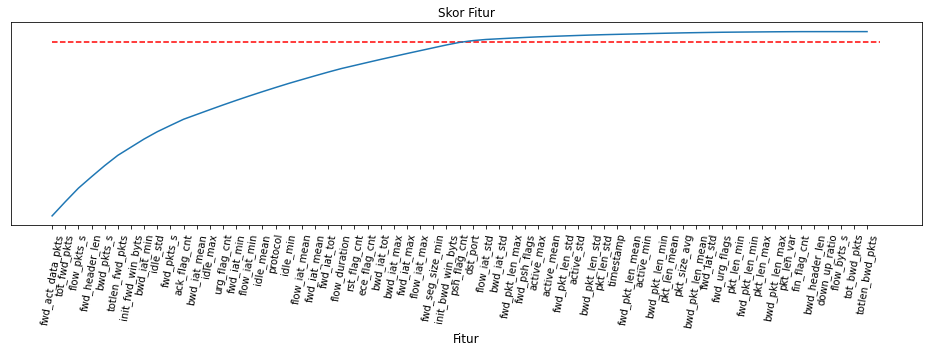

In [11]:
# Seleksi fitur dengan 'chi squared' #
# ================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 95

# vektor target
vektor_target = y_train['label']

# fitur terpilih dan fitur dihapus
fit_chi = seleksi_fitur(chi2, X_train_norm, vektor_target)
fitur_dihapus_chi,fitur_terpilih_chi = fitur_terbaik (fit_chi, persentase_skor, X_train_norm, 'chi')

# hapus fitur dengan skor terendah
X_train_chi = X_train_norm.drop(fitur_dihapus_chi, axis=1)
X_test_chi = X_test_norm.drop(fitur_dihapus_chi, axis=1)

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'chi squared' : ", s_sf - m_sf)

In [12]:
# label aktual dan jumlah fitur #
# ============================= #

# label aktual multi kelas
y_aktual_multi = y_test['label'].reset_index(drop=True)

# fitur dan jumlah fitur yang digunakan
print ('Fitur yang digunakan')
print ('====================')
print (list(X_train_chi.columns))
print ('')
print ('Jumlah fitur')
print ('============')
print (len(X_train_chi.columns),'fitur')

Fitur yang digunakan
['protocol', 'flow_duration', 'tot_fwd_pkts', 'totlen_fwd_pkts', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_max', 'bwd_iat_min', 'fwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'ece_flag_cnt', 'init_fwd_win_byts', 'init_bwd_win_byts', 'fwd_act_data_pkts', 'fwd_seg_size_min', 'idle_mean', 'idle_std', 'idle_max', 'idle_min']

Jumlah fitur
32 fitur


### 81.2. Pemilihan jumlah 'tree'

In [14]:
# Pemilihan jumlah 'trees' #
# ======================== #

m_jlh = time.time()

# parameter yang digunakan
param_klf = [{'random_state':42, 'n_jobs':-1}]                
jlh_estimator = [10,15,20,25,30,35,40,45,50]

# hasil pelatihan
latih_eval_rf(param_klf, jlh_estimator, y_aktual_multi)

s_jlh = time.time()
print ("Lama waktu pencarian jumlah 'tree' : ", s_jlh - m_jlh)

jumlah 'trees' : 10
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 225.94921731948853
Lama waktu prediksi : 3.2131497859954834
hasil 'Accuracy'    : 0.9815032429674975
hasil 'f1-score'    : 0.8694023209675469

jumlah 'trees' : 15
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 277.9090132713318
Lama waktu prediksi : 4.307190418243408
hasil 'Accuracy'    : 0.98159980323568
hasil 'f1-score'    : 0.8651485530550344

jumlah 'trees' : 20
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 353.29496812820435
Lama waktu prediksi : 5.717403411865234
hasil 'Accuracy'    : 0.9814604285089638
hasil 'f1-score'    : 0.8675284134510117

jumlah 'trees' : 25
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 448.9816520214081
Lama waktu prediksi : 6.810926675796509
hasil 'Accuracy'    : 0.9814335556041394
hasil 'f1-score'    : 0.8657863360978174

jumlah 'trees' : 30
hyperparameter : {'random_state': 42, '

In [15]:
# list hasil pelatihan
print ('List hasil pelatihan')
print ('====================')
print ('hasil_waktu_latih    =', hasil_waktu_latih)
print ('hasil_waktu_prediksi =', hasil_waktu_pred)
print ('hasil_f1_macro       =', hasil_f1_macro)
print ('hasil_akurasi        =', hasil_akurasi)
print ('jumlah_estimator     =', jlh_estimator)

List hasil pelatihan
hasil_waktu_latih    = [225.94921731948853, 277.9090132713318, 353.29496812820435, 448.9816520214081, 501.06621766090393, 602.6256411075592, 673.644734621048, 749.0625565052032, 841.1055061817169]
hasil_waktu_prediksi = [3.2131497859954834, 4.307190418243408, 5.717403411865234, 6.810926675796509, 8.044978380203247, 9.216570615768433, 10.341309785842896, 11.66912031173706, 13.762373924255371]
hasil_f1_macro       = [0.8694023209675469, 0.8651485530550344, 0.8675284134510117, 0.8657863360978174, 0.8671248358250699, 0.8671307124700126, 0.8658041280378698, 0.8661420219801744, 0.8667101081837145]
hasil_akurasi        = [0.9815032429674975, 0.98159980323568, 0.9814604285089638, 0.9814335556041394, 0.9816066353301268, 0.9814535964145168, 0.9814453979011806, 0.9816134674245737, 0.9815292049263956]
jumlah_estimator     = [10, 15, 20, 25, 30, 35, 40, 45, 50]


#### 81.2.1. Plot hasil pengukuran


 PLOT WAKTU LATIH


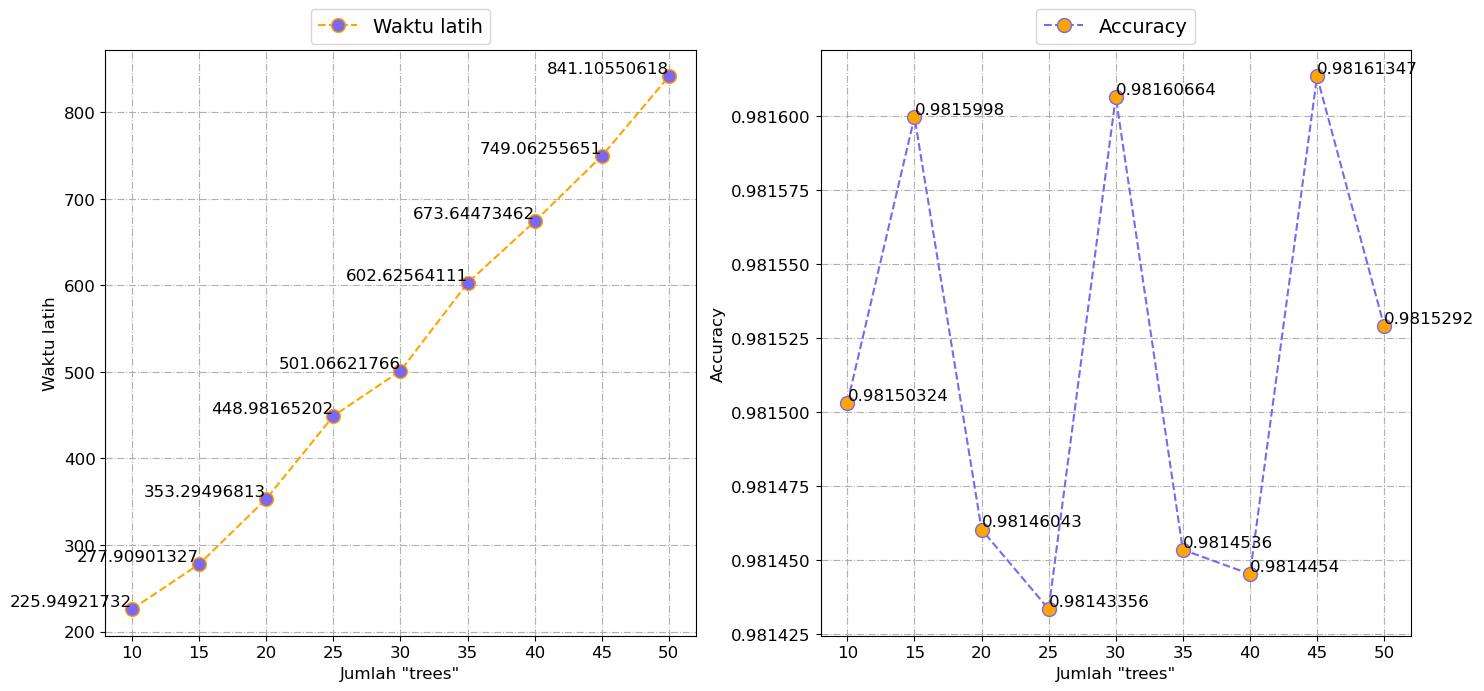


 PLOT WAKTU PREDIKSI


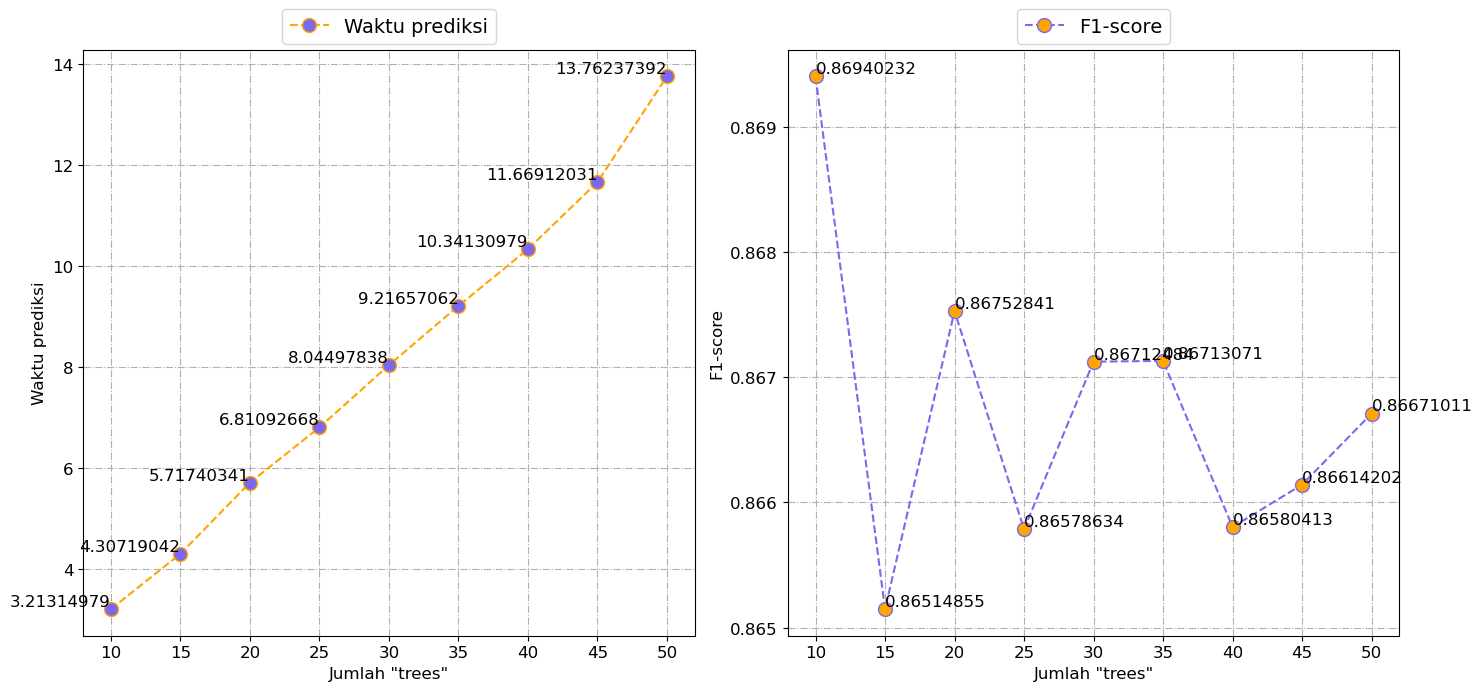


 PLOT WAKTU LATIH


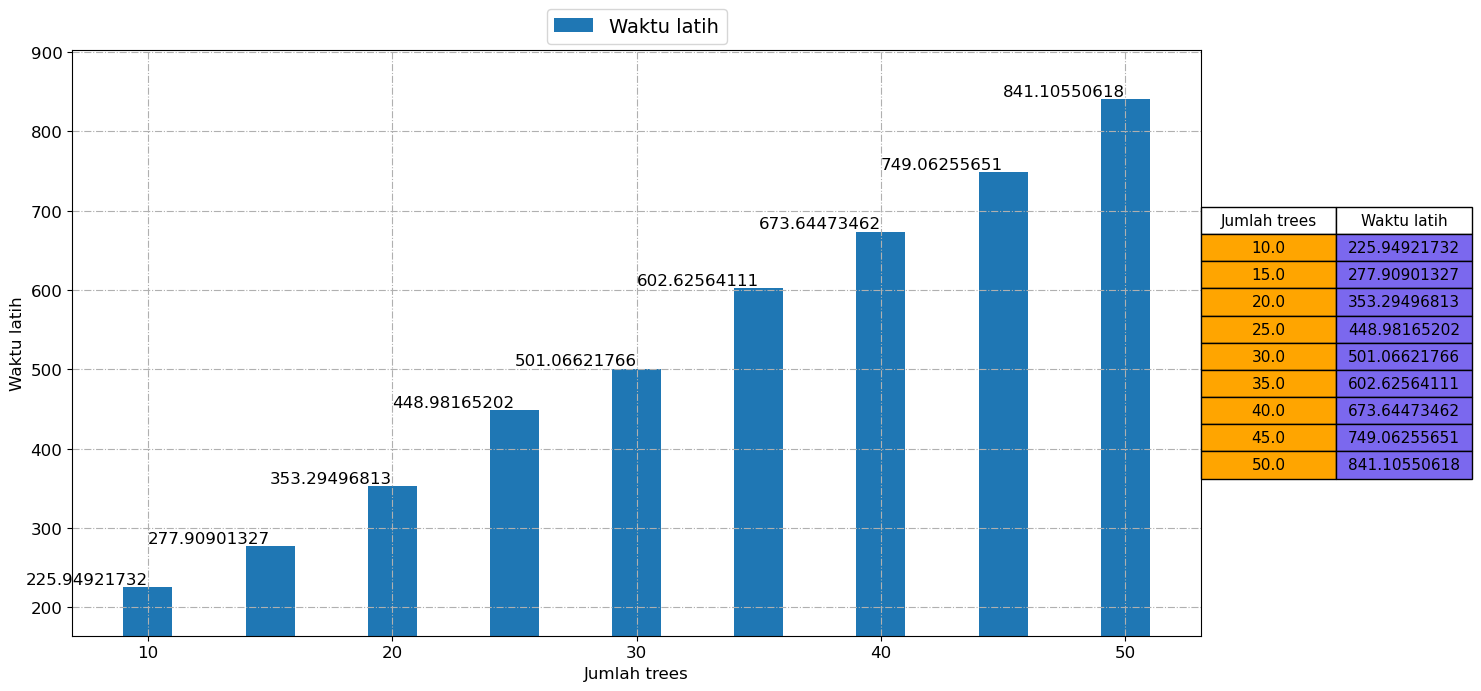


 PLOT WAKTU PREDIKSI


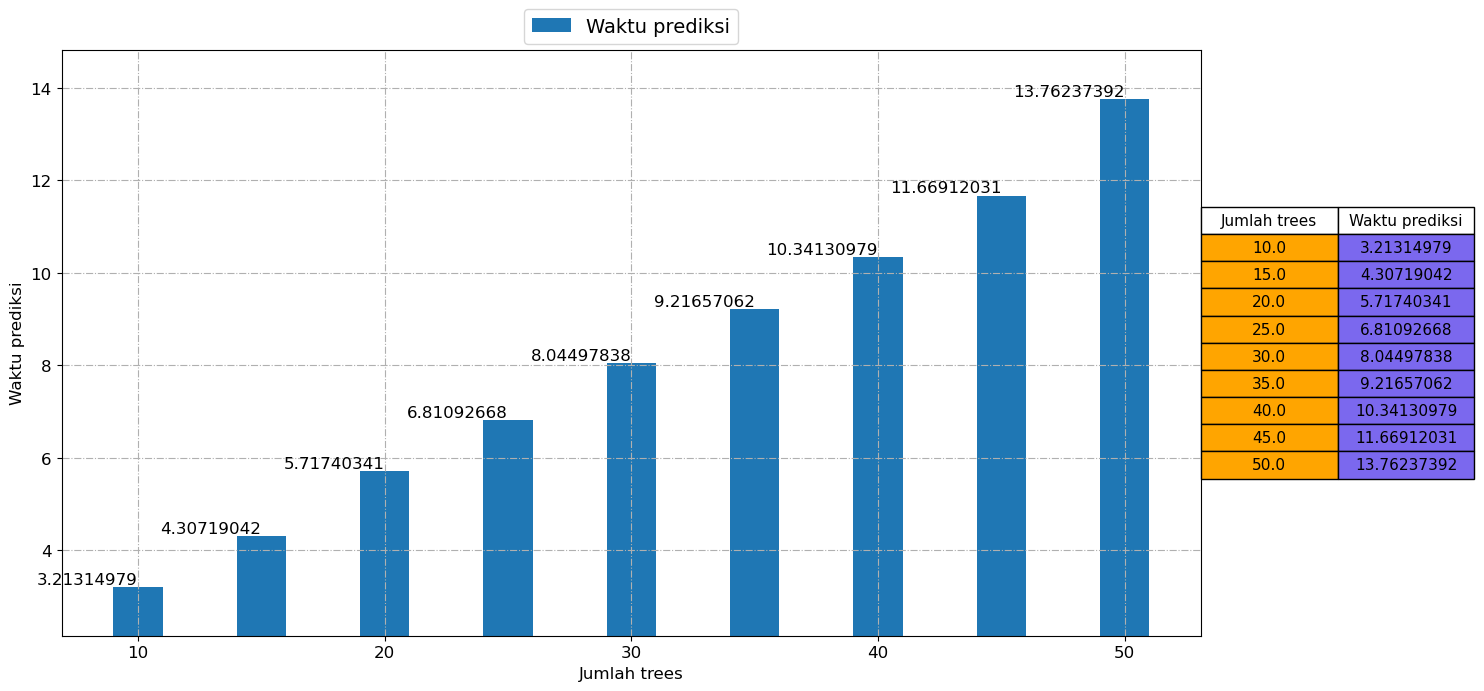


 PLOT ACCURACY


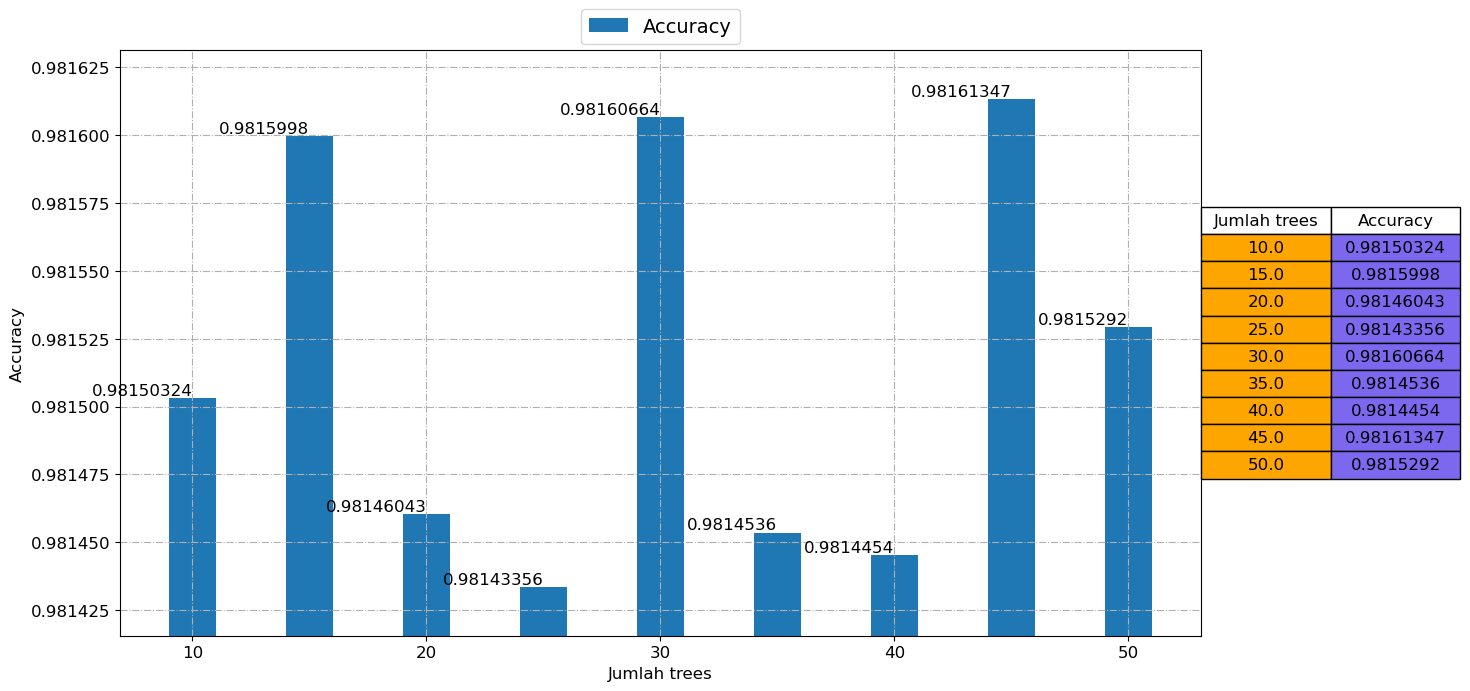


 PLOT F1-SCORE


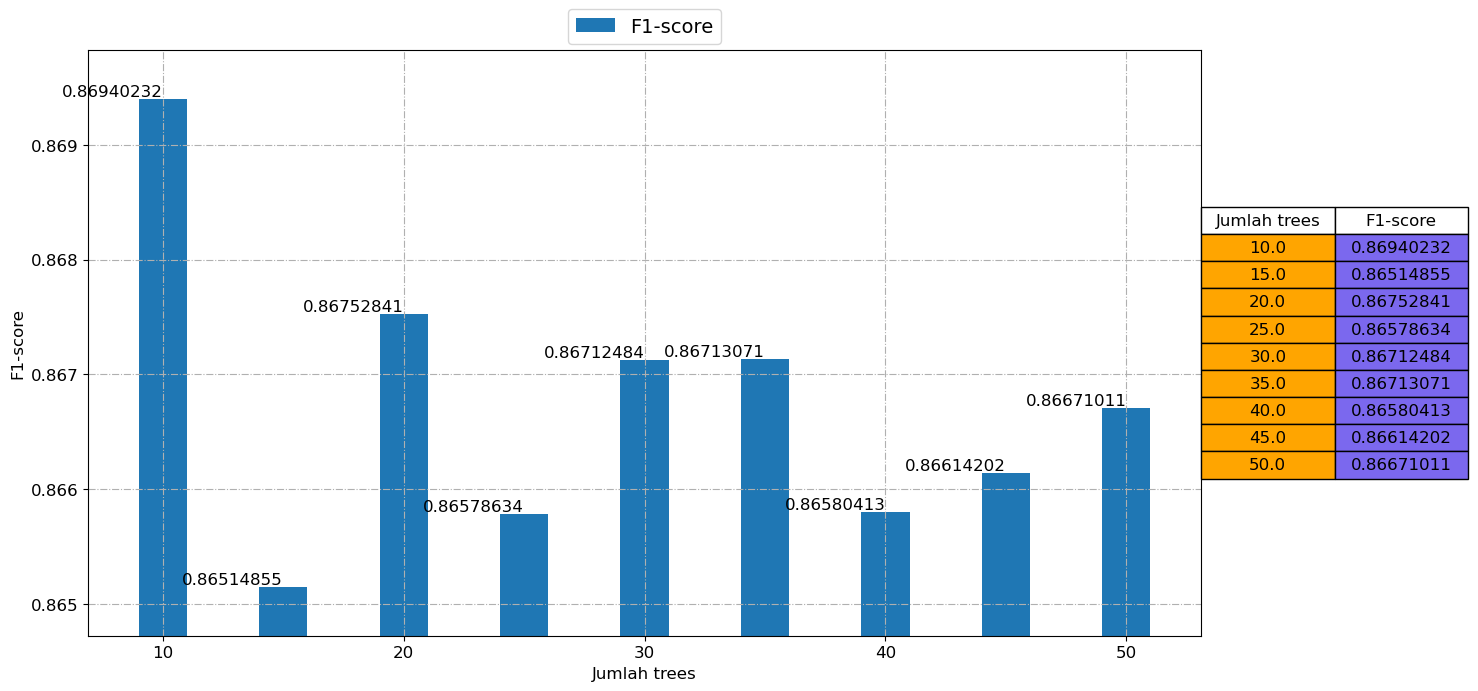

In [16]:
# Plot hasil pengukuran #
# ===================== #

# Plot waktu latih dan akurasi
plot_eval(hasil_waktu_latih,hasil_akurasi,jumlah_estimator,'Jumlah "trees"','Waktu latih','Accuracy')

# Plot waktu prediksi dan akurasi
plot_eval(hasil_waktu_pred,hasil_f1_macro,jumlah_estimator,'Jumlah "trees"','Waktu prediksi','F1-score')

# Plot waktu pelatihan
plot_eval(None,hasil_waktu_latih,jumlah_estimator,'Jumlah trees','Waktu latih',None)

# Plot waktu prediksi
plot_eval(None,hasil_waktu_pred,jumlah_estimator,'Jumlah trees','Waktu prediksi',None)

# Plot Akurasi
plot_eval(None,hasil_akurasi,jumlah_estimator,'Jumlah trees','Accuracy',None)

# plot F1
plot_eval(None,hasil_f1_macro,jumlah_estimator,'Jumlah trees','F1-score',None)

### 81.3. Hyperparameter tuning random forest

In [14]:
# Hyperparameter tuning random forest #
# =================================== #

m_hyper = time.time()

# hyperparameter yang digunakan untuk tuning
jlh_estimator     = [10]
max_features      = [5, 9, 12, 15, 18]
max_depth         = [None,5,10,15,20,25,30,35]
min_samples_split = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
min_samples_leaf  = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# pembangunan model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# jumlah acak kombinasi nilai hyperparameter
n_iter = 15

# validasi silang 5 lipatan
cv = 5

# tentukan f1 macro
f1_macro_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

# random grid search
random_grid = {'n_estimators': jlh_estimator,'max_depth': max_depth,'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,'max_features': max_features}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter=n_iter, cv=cv, verbose=10, random_state=17, n_jobs=None, scoring=f1_macro_scorer)

# terapkan random grid pada data latih
rf_random.fit(X_train_chi, y_train['label'])

s_hyper = time.time()
print ("Lama waktu 'hyperparameter tuning' : ", s_hyper - m_hyper)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=30, max_features=5, min_samples_leaf=3, min_samples_split=16, n_estimators=10
[CV 1/5; 1/15] END max_depth=30, max_features=5, min_samples_leaf=3, min_samples_split=16, n_estimators=10;, score=0.828 total time= 3.5min
[CV 2/5; 1/15] START max_depth=30, max_features=5, min_samples_leaf=3, min_samples_split=16, n_estimators=10
[CV 2/5; 1/15] END max_depth=30, max_features=5, min_samples_leaf=3, min_samples_split=16, n_estimators=10;, score=0.832 total time= 3.2min
[CV 3/5; 1/15] START max_depth=30, max_features=5, min_samples_leaf=3, min_samples_split=16, n_estimators=10
[CV 3/5; 1/15] END max_depth=30, max_features=5, min_samples_leaf=3, min_samples_split=16, n_estimators=10;, score=0.838 total time= 3.2min
[CV 4/5; 1/15] START max_depth=30, max_features=5, min_samples_leaf=3, min_samples_split=16, n_estimators=10
[CV 4/5; 1/15] END max_depth=30, max_features=5, min_samples_leaf=3, min_samples_sp

[CV 4/5; 7/15] END max_depth=15, max_features=9, min_samples_leaf=17, min_samples_split=2, n_estimators=10;, score=0.802 total time= 3.3min
[CV 5/5; 7/15] START max_depth=15, max_features=9, min_samples_leaf=17, min_samples_split=2, n_estimators=10
[CV 5/5; 7/15] END max_depth=15, max_features=9, min_samples_leaf=17, min_samples_split=2, n_estimators=10;, score=0.811 total time= 3.4min
[CV 1/5; 8/15] START max_depth=20, max_features=15, min_samples_leaf=10, min_samples_split=17, n_estimators=10
[CV 1/5; 8/15] END max_depth=20, max_features=15, min_samples_leaf=10, min_samples_split=17, n_estimators=10;, score=0.828 total time= 6.3min
[CV 2/5; 8/15] START max_depth=20, max_features=15, min_samples_leaf=10, min_samples_split=17, n_estimators=10
[CV 2/5; 8/15] END max_depth=20, max_features=15, min_samples_leaf=10, min_samples_split=17, n_estimators=10;, score=0.819 total time= 6.1min
[CV 3/5; 8/15] START max_depth=20, max_features=15, min_samples_leaf=10, min_samples_split=17, n_estimato

[CV 2/5; 14/15] END max_depth=5, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=0.576 total time= 2.5min
[CV 3/5; 14/15] START max_depth=5, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=10
[CV 3/5; 14/15] END max_depth=5, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=0.565 total time= 2.6min
[CV 4/5; 14/15] START max_depth=5, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=10
[CV 4/5; 14/15] END max_depth=5, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=0.564 total time= 2.6min
[CV 5/5; 14/15] START max_depth=5, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=10
[CV 5/5; 14/15] END max_depth=5, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=10;, score=0.537 total time= 2.5min
[CV 1/5; 15/15] START max_depth=None, max_features=18, min_samples_leaf=19, min_samples_split=9, n_estimators=10


In [15]:
# Hasil tuning hyperparameter #
# =========================== #

# hasil
print ('F1 skor dan parameter terbaik')
print ('=============================')
print ('Nilai F1 skor terbaik : %s' % rf_random.best_score_)
print ('Parameter terbaik     : %s' % rf_random.best_params_)
print ('Estimator terbaik     : %s' % rf_random.best_estimator_)
test_81_rf_new_params_2 = pd.DataFrame(rf_random.cv_results_)

# simpan hasil hyperparameter random forest
test_81_rf_new_params_2.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_81_rf_new_params_2.txt", index=False)

F1 skor dan parameter terbaik
Nilai F1 skor terbaik : 0.8496633609632551
Parameter terbaik     : {'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 15, 'max_depth': 35}
Estimator terbaik     : RandomForestClassifier(max_depth=35, max_features=15, min_samples_leaf=7,
                       min_samples_split=20, n_estimators=10, n_jobs=-1,
                       random_state=42)


### 81.4. Hyperparameter terbaik

In [13]:
# 5 hyperparameter terbaik #
# ======================== #

# hyperparameter terbaik
hyperparam_rf = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_81_rf_new_params_2.txt")

# mengurutkan hyperparameter terbaik berdasarkan f1
hyperparam_rf = hyperparam_rf.sort_values("rank_test_score")

# menampilkan 5 hyperparameter terbaik
print ('5 hyperparameter terbaik berdasarkan f1')
print ('=======================================')
param = hyperparam_rf[['rank_test_score','params','mean_fit_time','mean_test_score']].reset_index(drop=True)
#param = param[['params']]
param.head(5)

5 hyperparameter terbaik berdasarkan f1


,rank_test_score,params,mean_fit_time,mean_test_score
0,1,"{'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 15, 'max_depth': 35}",408.724214,0.849663
1,2,"{'n_estimators': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 9, 'max_depth': None}",290.948904,0.848173
2,3,"{'n_estimators': 10, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 30}",178.873136,0.836824
3,4,"{'n_estimators': 10, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 9, 'max_depth': 25}",232.694630,0.831834
4,5,"{'n_estimators': 10, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 15, 'max_depth': 20}",342.191478,0.828443


#### 81.4.1.  Latih hyperparameter terbaik berdasarkan f1

In [14]:
param_rf = param['params'][0]
param_terbaik = [eval(param_rf)]   

# jumlah estimator
for n in param_terbaik:
    jlh_estimator = [n['n_estimators']]
    
param_terbaik

[{'n_estimators': 10,
  'min_samples_split': 20,
  'min_samples_leaf': 7,
  'max_features': 15,
  'max_depth': 35}]

In [15]:
print ('|=======================================|')
print ("| Hyperparameter terbaik berdasarkan f1 |")
print ('|=======================================|')
print ('')
klf_f1, y_f1 = latih_eval_rf(param_terbaik, jlh_estimator, y_aktual_multi)

|=======================================|
| Hyperparameter terbaik berdasarkan f1 |
|=======================================|

hyperparameter : {'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 15, 'max_depth': 35}
Lama waktu latih    : 333.37197375297546
Lama waktu prediksi : 2.517866611480713
hasil 'Accuracy'    : 0.9828573640868679
hasil 'f1-score'    : 0.8653405210810127



#### 81.4.2. Evaluasi model


Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9828573640868679
Precision : 0.9433700061817479
Recall    : 0.8362074447947663
F1-score  : 0.8653405210810127

metrik evaluasi :
                          precision    recall  f1-score   support

                  benign   0.988764  0.999481  0.994094   1646640
                     bot   0.993235  0.998654  0.995937     57187
        brute_force__web   0.918182  0.855932  0.885965       118
        brute_force__xss   1.000000  0.717391  0.835443        46
        ddos_attack_hoic   1.000000  1.000000  1.000000    137202
    ddos_attack_loic_udp   0.809019  0.881503  0.843707       346
  ddos_attacks_loic_http   0.999497  0.999115  0.999306    115238
   dos_attacks_goldeneye   0.999759  0.999880  0.999819      8302
        dos_attacks_hulk   0.999957  1.000000  0.999978     92382
dos_attacks_slowhttptest   0.773031  0.508364  0.613364     27978
   dos_attacks_slowloris   0.985395  0.982257  0.983823      2198
          ftp_brutef

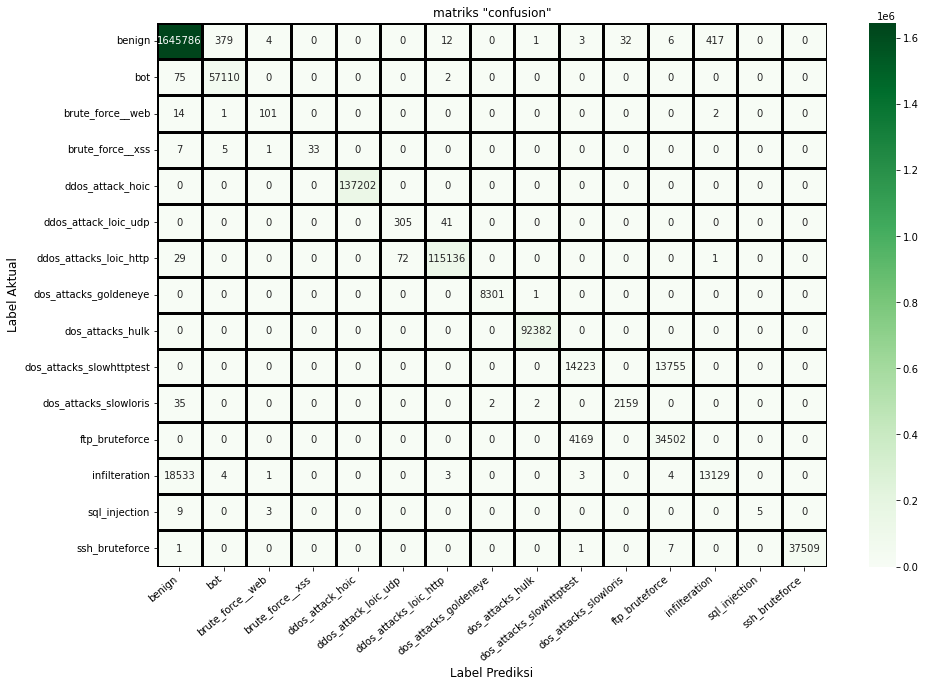

misklasifikasi kelas target:
                          misklasifikasi    total  \
sql_injection                         12       17   
infilteration                      18548    31677   
dos_attacks_slowhttptest           13755    27978   
brute_force__xss                      13       46   
brute_force__web                      17      118   
ddos_attack_loic_udp                  41      346   
ftp_bruteforce                      4169    38671   
dos_attacks_slowloris                 39     2198   
bot                                   77    57187   
ddos_attacks_loic_http               102   115238   
benign                               854  1646640   
ssh_bruteforce                         9    37518   
dos_attacks_goldeneye                  1     8302   
ddos_attack_hoic                       0   137202   
dos_attacks_hulk                       0    92382   

                          persentase_misklasifikasi(%)  
sql_injection                                70.588235  
infilter

In [16]:
# metrik evaluasi lapisan 3 berdasarkan f1
metrik (klf_f1, 2, y_aktual_multi, y_f1)

# misklasifikasi lapisan 3
misklasifikasi(y_aktual_multi, y_f1)

# =========================================

## Test 82

### 82.1. Seleksi fitur chi squared - 99%

Fitur yang dihapus
['bwd_pkt_len_min', 'pkt_len_mean', 'pkt_size_avg', 'bwd_pkt_len_mean', 'fwd_iat_std', 'fwd_urg_flags', 'pkt_len_min', 'fwd_pkt_len_min', 'pkt_len_max', 'bwd_pkt_len_max', 'pkt_len_var', 'fin_flag_cnt', 'bwd_header_len', 'down_up_ratio', 'flow_byts_s', 'tot_bwd_pkts', 'totlen_bwd_pkts']


Fitur dengan skor terbaik
    Skor Chi-kuadrat              Fitur  Persentase skor  jumlah persentase
1       2.409937e+06  fwd_act_data_pkts         7.434345           7.434345
2       2.296485e+06       tot_fwd_pkts         7.084360          14.518704
3       2.215494e+06        flow_pkts_s         6.834514          21.353218
4       1.862728e+06     fwd_header_len         5.746274          27.099492
5       1.811408e+06         bwd_pkts_s         5.587960          32.687452
6       1.673186e+06    totlen_fwd_pkts         5.161564          37.849016
7       1.331233e+06  init_fwd_win_byts         4.106681          41.955697
8       1.327604e+06        bwd_iat_min         4.095486 

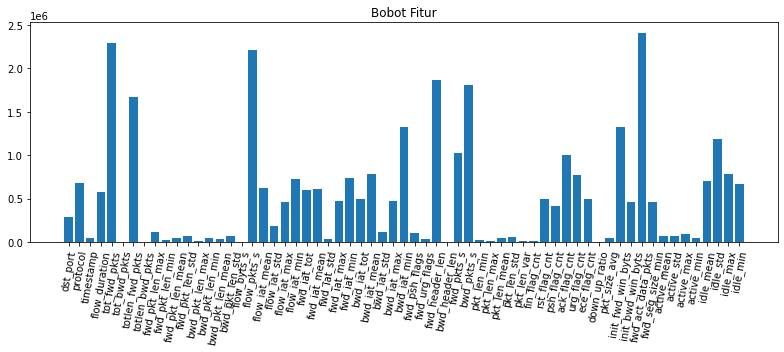

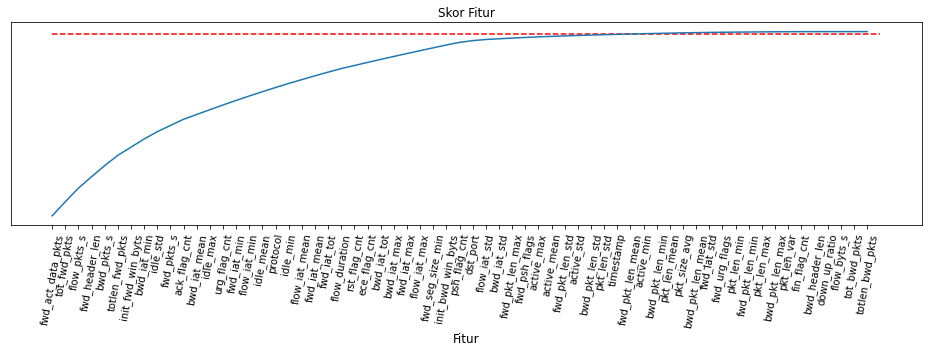

In [17]:
# Seleksi fitur dengan 'chi squared' #
# ================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 99

# vektor target
vektor_target = y_train['label']

# fitur terpilih dan fitur dihapus
fit_chi = seleksi_fitur(chi2, X_train_norm, vektor_target)
fitur_dihapus_chi,fitur_terpilih_chi = fitur_terbaik (fit_chi, persentase_skor, X_train_norm, 'chi')

# hapus fitur dengan skor terendah
X_train_chi = X_train_norm.drop(fitur_dihapus_chi, axis=1)
X_test_chi = X_test_norm.drop(fitur_dihapus_chi, axis=1)

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'chi squared' : ", s_sf - m_sf)

In [18]:
# label aktual dan jumlah fitur #
# ============================= #

# label aktual biner kelas
y_aktual_multi = y_test['label'].reset_index(drop=True)

# fitur dan jumlah fitur yang digunakan
print ('Fitur yang digunakan')
print ('====================')
print (list(X_train_chi.columns))
print ('')
print ('Jumlah fitur')
print ('============')
print (len(X_train_chi.columns),'fitur')

Fitur yang digunakan
['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts', 'totlen_fwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_std', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s', 'pkt_len_std', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'ece_flag_cnt', 'init_fwd_win_byts', 'init_bwd_win_byts', 'fwd_act_data_pkts', 'fwd_seg_size_min', 'active_mean', 'active_std', 'active_max', 'active_min', 'idle_mean', 'idle_std', 'idle_max', 'idle_min']

Jumlah fitur
46 fitur


### 82.2. Pemilihan jumlah 'tree'

In [26]:
# Pemilihan jumlah 'trees' #
# ======================== #

m_jlh = time.time()

# parameter yang digunakan
param_klf = [{'random_state':42, 'n_jobs':-1}]                
jlh_estimator = [10,15,20,25,30,35,40,45,50]

# hasil pelatihan
latih_eval_rf(param_klf, jlh_estimator, y_aktual_multi)

s_jlh = time.time()
print ("Lama waktu pencarian jumlah 'tree' : ", s_jlh - m_jlh)

jumlah 'trees' : 10
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 197.44135642051697
Lama waktu prediksi : 2.9666175842285156
hasil 'Accuracy'    : 0.9958898119807609
hasil 'f1-score'    : 0.9473966768563158

jumlah 'trees' : 15
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 278.6375114917755
Lama waktu prediksi : 5.075043678283691
hasil 'Accuracy'    : 0.9959394585337414
hasil 'f1-score'    : 0.9530263809818351

jumlah 'trees' : 20
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 365.8054416179657
Lama waktu prediksi : 5.560036659240723
hasil 'Accuracy'    : 0.9959226060341058
hasil 'f1-score'    : 0.9486791587312383

jumlah 'trees' : 25
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 449.1385908126831
Lama waktu prediksi : 7.412264585494995
hasil 'Accuracy'    : 0.9959695197493077
hasil 'f1-score'    : 0.947505502105811

jumlah 'trees' : 30
hyperparameter : {'random_state': 42, '

In [27]:
# list hasil pelatihan
print ('List hasil pelatihan')
print ('====================')
print ('hasil_waktu_latih    =', hasil_waktu_latih)
print ('hasil_waktu_prediksi =', hasil_waktu_pred)
print ('hasil_f1_macro       =', hasil_f1_macro)
print ('hasil_akurasi        =', hasil_akurasi)
print ('jumlah_estimator     =', jlh_estimator)

List hasil pelatihan
hasil_waktu_latih    = [197.44135642051697, 278.6375114917755, 365.8054416179657, 449.1385908126831, 519.4241271018982, 610.4530909061432, 683.5539743900299, 766.2159616947174, 852.5701427459717]
hasil_waktu_prediksi = [2.9666175842285156, 5.075043678283691, 5.560036659240723, 7.412264585494995, 6.920241594314575, 7.779407739639282, 9.274055242538452, 11.582246541976929, 11.047460317611694]
hasil_f1_macro       = [0.9473966768563158, 0.9530263809818351, 0.9486791587312383, 0.947505502105811, 0.9470147754043344, 0.9466059814088773, 0.9469826077562479, 0.9466015850079316, 0.9465955326672911]
hasil_akurasi        = [0.9958898119807609, 0.9959394585337414, 0.9959226060341058, 0.9959695197493077, 0.9959845503570908, 0.9959758963707914, 0.9959649650196765, 0.9959777182626439, 0.9959777182626439]
jumlah_estimator     = [10, 15, 20, 25, 30, 35, 40, 45, 50]


#### 82.2.1. Plot hasil pengukuran


 PLOT WAKTU LATIH


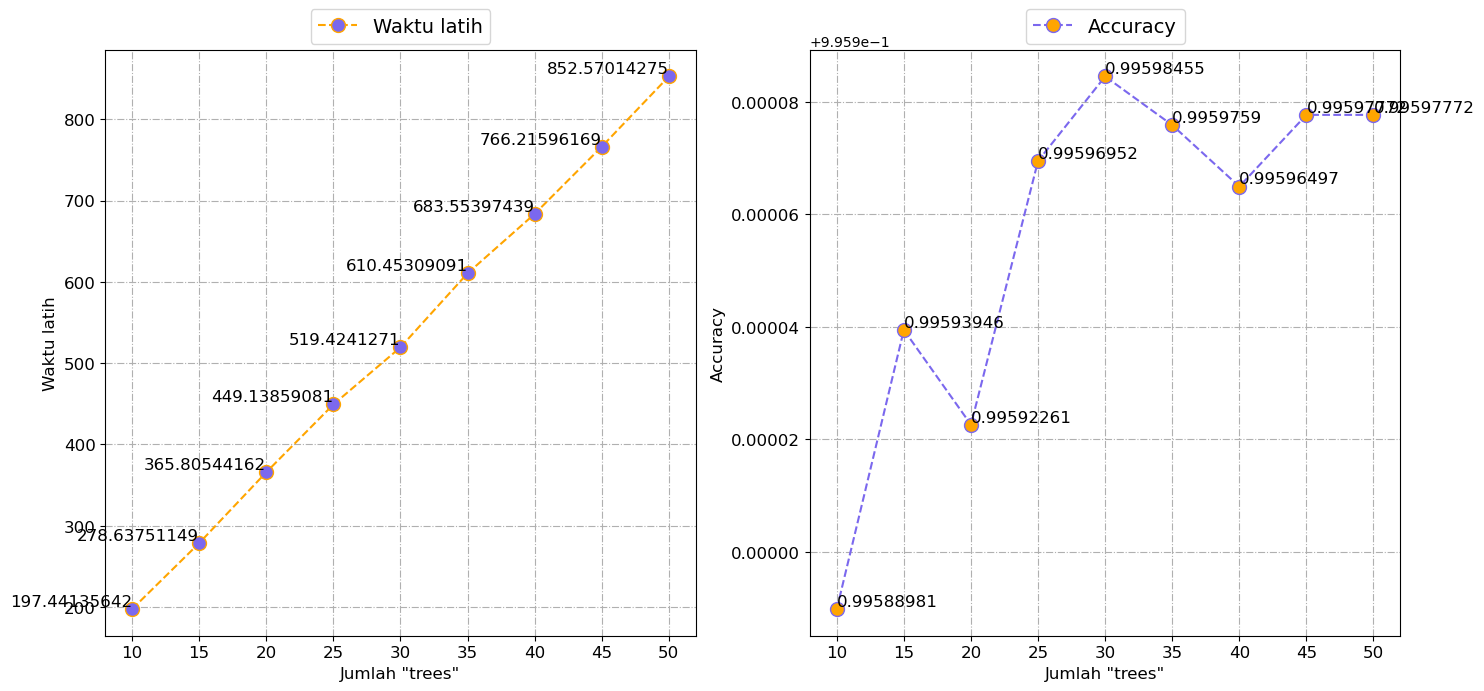


 PLOT WAKTU PREDIKSI


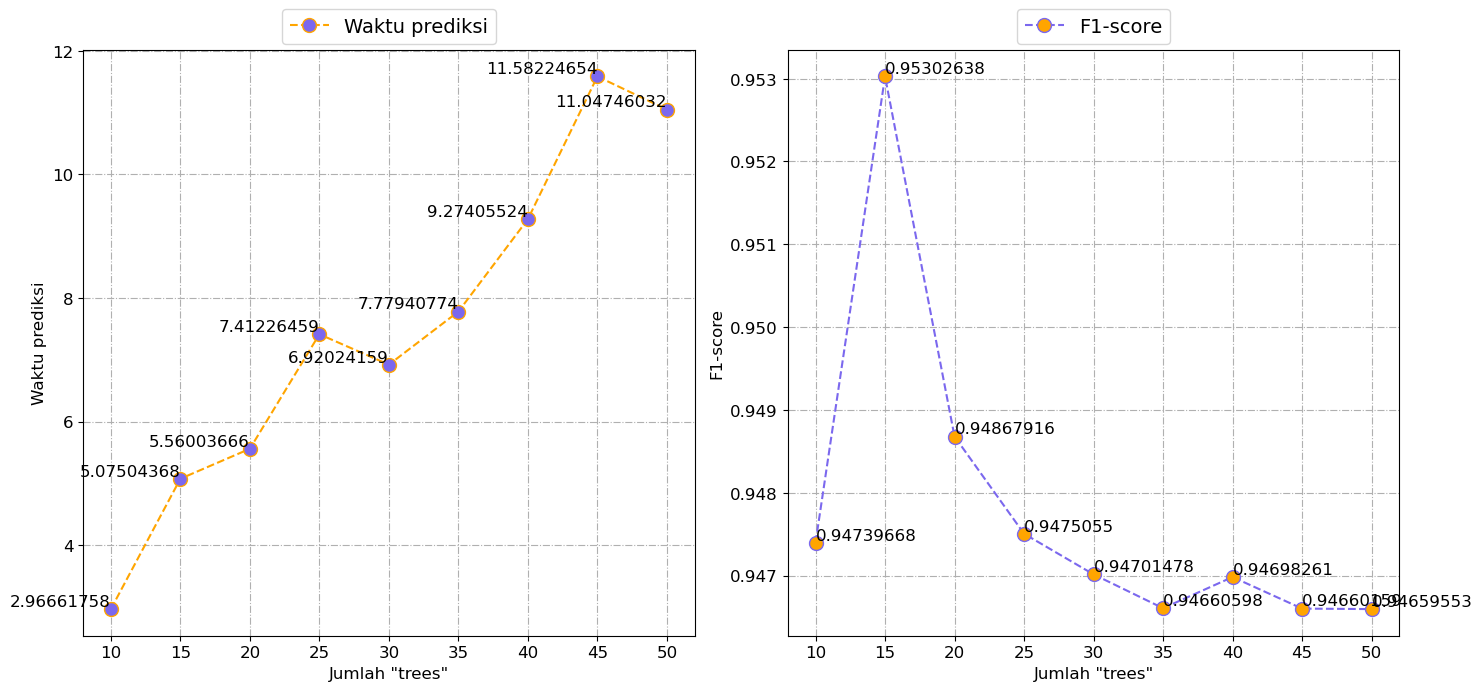


 PLOT WAKTU LATIH


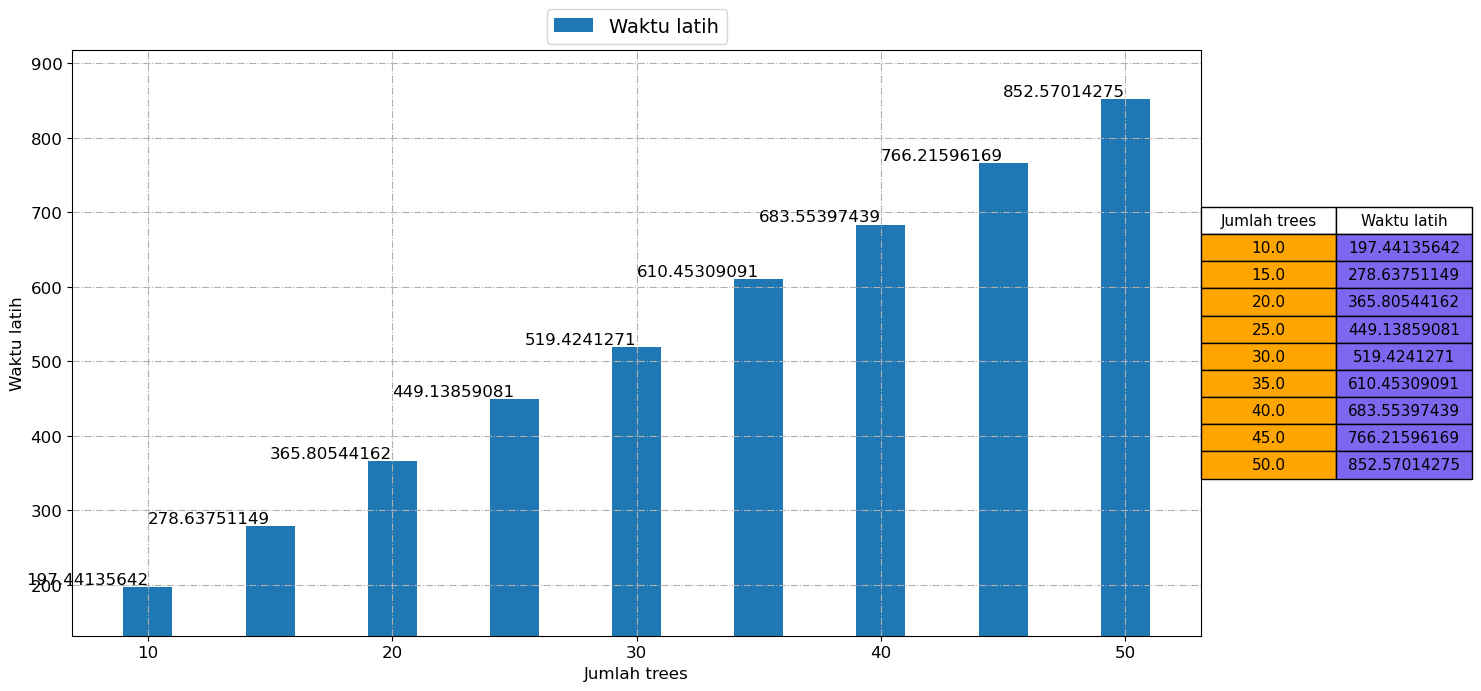


 PLOT WAKTU PREDIKSI


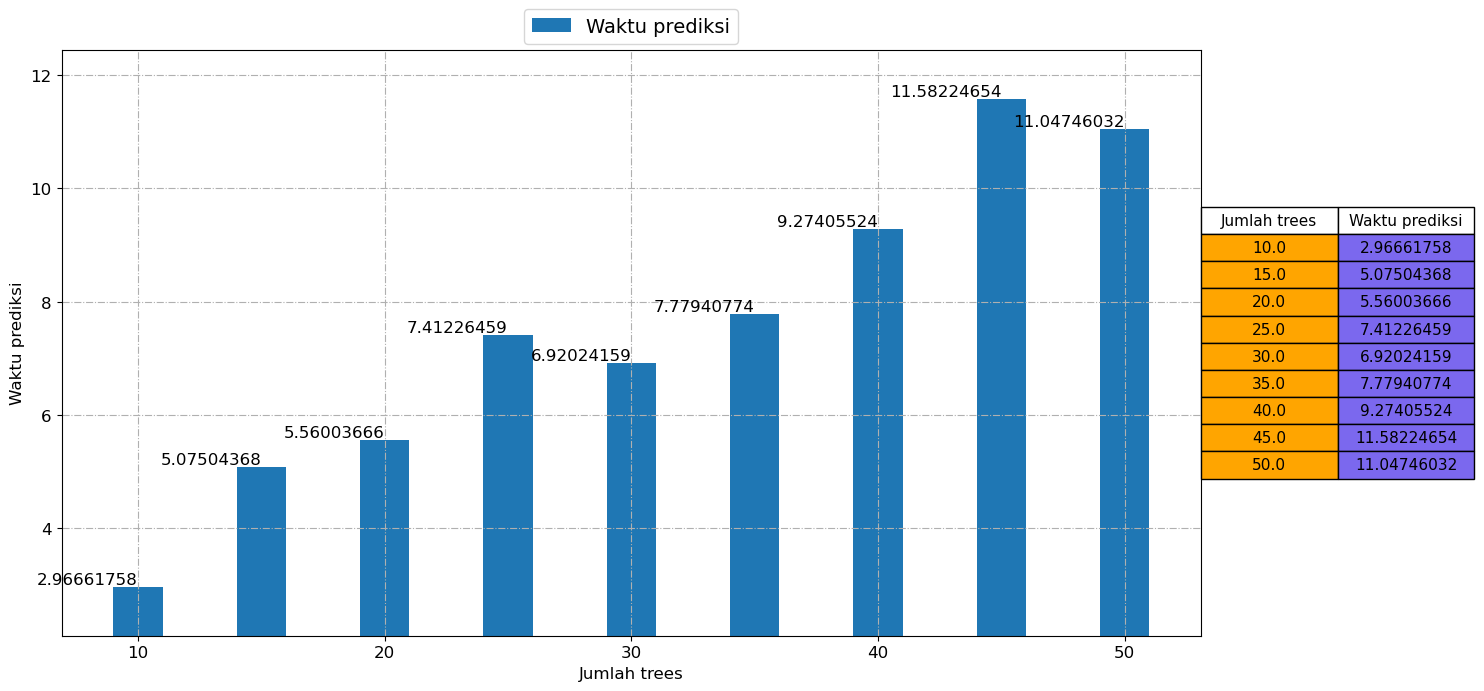


 PLOT ACCURACY


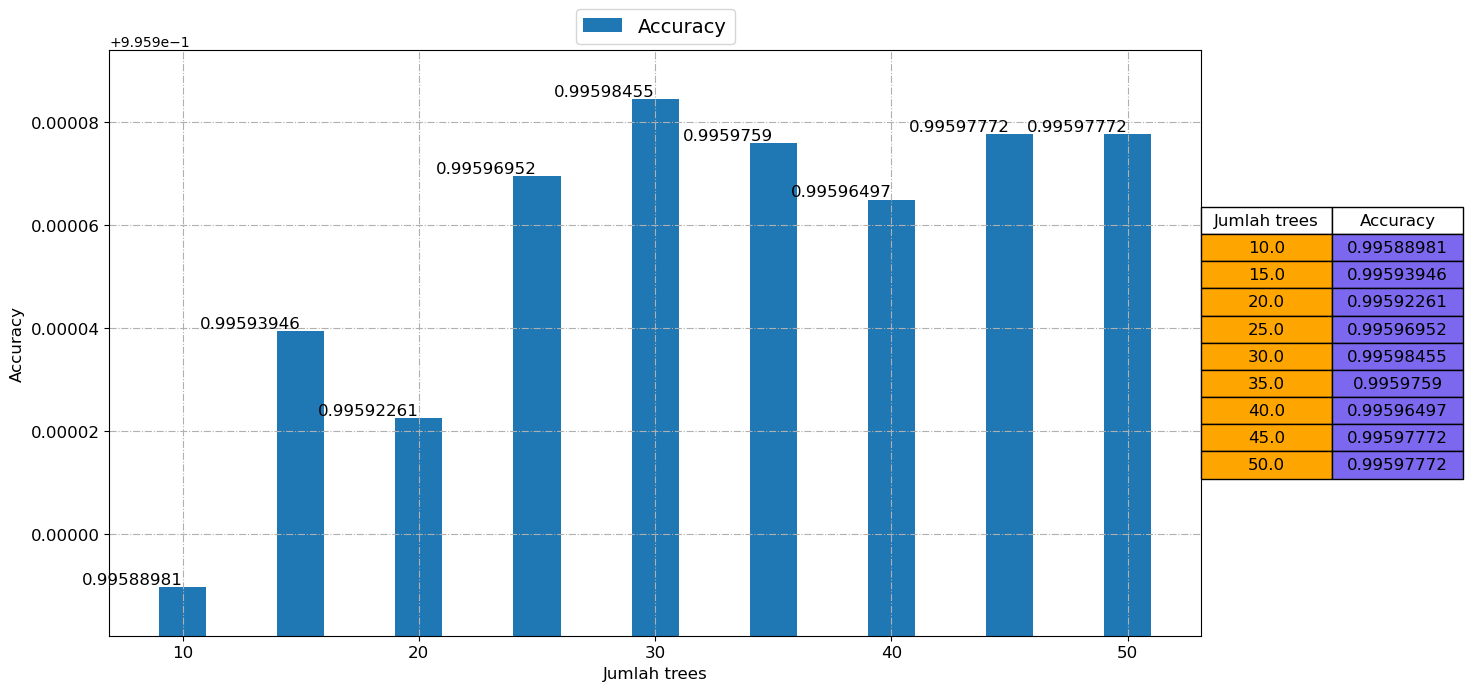


 PLOT F1-SCORE


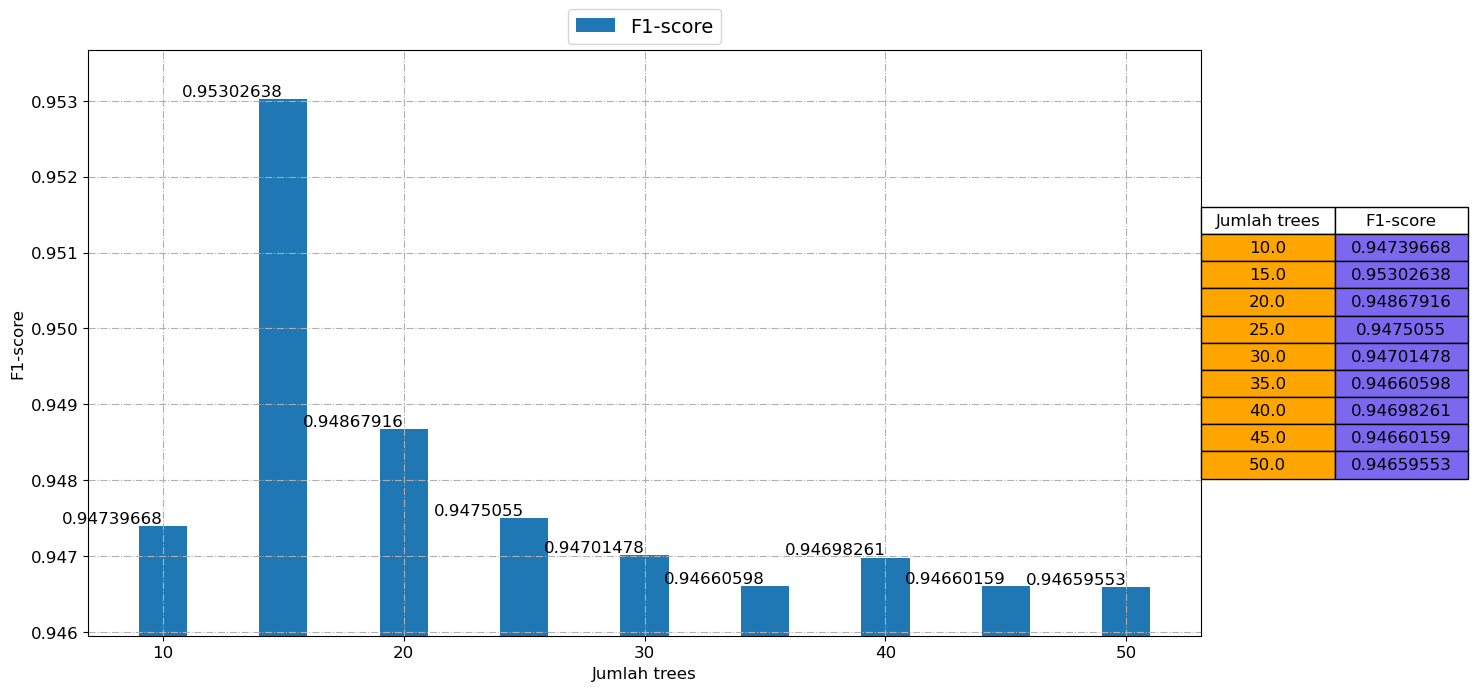

In [28]:
# Plot hasil pengukuran #
# ===================== #

# Plot waktu latih dan akurasi
plot_eval(hasil_waktu_latih,hasil_akurasi,jumlah_estimator,'Jumlah "trees"','Waktu latih','Accuracy')

# Plot waktu prediksi dan akurasi
plot_eval(hasil_waktu_pred,hasil_f1_macro,jumlah_estimator,'Jumlah "trees"','Waktu prediksi','F1-score')

# Plot waktu pelatihan
plot_eval(None,hasil_waktu_latih,jumlah_estimator,'Jumlah trees','Waktu latih',None)

# Plot waktu prediksi
plot_eval(None,hasil_waktu_pred,jumlah_estimator,'Jumlah trees','Waktu prediksi',None)

# Plot Akurasi
plot_eval(None,hasil_akurasi,jumlah_estimator,'Jumlah trees','Accuracy',None)

# plot F1
plot_eval(None,hasil_f1_macro,jumlah_estimator,'Jumlah trees','F1-score',None)

### 82.3. Hyperparameter tuning random forest

In [23]:
# Hyperparameter tuning random forest #
# =================================== #

m_hyper = time.time()

# hyperparameter yang digunakan untuk tuning
jlh_estimator     = [15]
max_features      = [5, 9, 12, 15, 18]
max_depth         = [None,5,10,15,20,25,30,35]
min_samples_split = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
min_samples_leaf  = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# pembangunan model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# jumlah acak kombinasi nilai hyperparameter
n_iter = 15

# validasi silang 5 lipatan
cv = 5

# tentukan f1 macro
f1_macro_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

# random grid search
random_grid = {'n_estimators': jlh_estimator,'max_depth': max_depth,'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,'max_features': max_features}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter=n_iter, cv=cv, verbose=10, random_state=18, n_jobs=None, scoring=f1_macro_scorer)

# terapkan random grid pada data latih
rf_random.fit(X_train_chi, y_train['label'])

s_hyper = time.time()
print ("Lama waktu 'hyperparameter tuning' : ", s_hyper - m_hyper)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=30, max_features=12, min_samples_leaf=2, min_samples_split=12, n_estimators=15
[CV 1/5; 1/15] END max_depth=30, max_features=12, min_samples_leaf=2, min_samples_split=12, n_estimators=15;, score=0.951 total time= 7.5min
[CV 2/5; 1/15] START max_depth=30, max_features=12, min_samples_leaf=2, min_samples_split=12, n_estimators=15
[CV 2/5; 1/15] END max_depth=30, max_features=12, min_samples_leaf=2, min_samples_split=12, n_estimators=15;, score=0.954 total time= 6.7min
[CV 3/5; 1/15] START max_depth=30, max_features=12, min_samples_leaf=2, min_samples_split=12, n_estimators=15
[CV 3/5; 1/15] END max_depth=30, max_features=12, min_samples_leaf=2, min_samples_split=12, n_estimators=15;, score=0.965 total time= 6.2min
[CV 4/5; 1/15] START max_depth=30, max_features=12, min_samples_leaf=2, min_samples_split=12, n_estimators=15
[CV 4/5; 1/15] END max_depth=30, max_features=12, min_samples_leaf=2, min_sa

[CV 3/5; 7/15] END max_depth=5, max_features=9, min_samples_leaf=8, min_samples_split=12, n_estimators=15;, score=0.601 total time= 2.3min
[CV 4/5; 7/15] START max_depth=5, max_features=9, min_samples_leaf=8, min_samples_split=12, n_estimators=15
[CV 4/5; 7/15] END max_depth=5, max_features=9, min_samples_leaf=8, min_samples_split=12, n_estimators=15;, score=0.583 total time= 2.3min
[CV 5/5; 7/15] START max_depth=5, max_features=9, min_samples_leaf=8, min_samples_split=12, n_estimators=15
[CV 5/5; 7/15] END max_depth=5, max_features=9, min_samples_leaf=8, min_samples_split=12, n_estimators=15;, score=0.615 total time= 2.3min
[CV 1/5; 8/15] START max_depth=35, max_features=5, min_samples_leaf=14, min_samples_split=5, n_estimators=15
[CV 1/5; 8/15] END max_depth=35, max_features=5, min_samples_leaf=14, min_samples_split=5, n_estimators=15;, score=0.884 total time= 3.7min
[CV 2/5; 8/15] START max_depth=35, max_features=5, min_samples_leaf=14, min_samples_split=5, n_estimators=15
[CV 2/5; 

[CV 1/5; 14/15] END max_depth=35, max_features=18, min_samples_leaf=6, min_samples_split=12, n_estimators=15;, score=0.951 total time= 8.5min
[CV 2/5; 14/15] START max_depth=35, max_features=18, min_samples_leaf=6, min_samples_split=12, n_estimators=15
[CV 2/5; 14/15] END max_depth=35, max_features=18, min_samples_leaf=6, min_samples_split=12, n_estimators=15;, score=0.947 total time= 8.6min
[CV 3/5; 14/15] START max_depth=35, max_features=18, min_samples_leaf=6, min_samples_split=12, n_estimators=15
[CV 3/5; 14/15] END max_depth=35, max_features=18, min_samples_leaf=6, min_samples_split=12, n_estimators=15;, score=0.950 total time= 9.8min
[CV 4/5; 14/15] START max_depth=35, max_features=18, min_samples_leaf=6, min_samples_split=12, n_estimators=15
[CV 4/5; 14/15] END max_depth=35, max_features=18, min_samples_leaf=6, min_samples_split=12, n_estimators=15;, score=0.957 total time= 9.7min
[CV 5/5; 14/15] START max_depth=35, max_features=18, min_samples_leaf=6, min_samples_split=12, n_es

In [24]:
# Hasil tuning hyperparameter #
# =========================== #

# hasil
print ('F1 skor dan parameter terbaik')
print ('=============================')
print ('Nilai F1 skor terbaik : %s' % rf_random.best_score_)
print ('Parameter terbaik     : %s' % rf_random.best_params_)
print ('Estimator terbaik     : %s' % rf_random.best_estimator_)
test_82_rf_new_params_2 = pd.DataFrame(rf_random.cv_results_)

# simpan hasil hyperparameter random forest
test_82_rf_new_params_2.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_82_rf_new_params_2.txt", index=False)

F1 skor dan parameter terbaik
Nilai F1 skor terbaik : 0.9615691388610316
Parameter terbaik     : {'n_estimators': 15, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 15, 'max_depth': 30}
Estimator terbaik     : RandomForestClassifier(max_depth=30, max_features=15, min_samples_leaf=2,
                       min_samples_split=17, n_estimators=15, n_jobs=-1,
                       random_state=42)


### 82.4. Hyperparameter terbaik

In [19]:
# 5 hyperparameter terbaik #
# ======================== #

# hyperparameter terbaik
hyperparam_rf = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_82_rf_new_params_2.txt")

# mengurutkan hyperparameter terbaik berdasarkan f1
hyperparam_rf = hyperparam_rf.sort_values("rank_test_score")

# menampilkan 5 hyperparameter terbaik
print ('5 hyperparameter terbaik berdasarkan f1')
print ('=======================================')
param = hyperparam_rf[['rank_test_score','params','mean_fit_time','mean_test_score']].reset_index(drop=True)
#param = param[['params']]
param.head(5)

5 hyperparameter terbaik berdasarkan f1


,rank_test_score,params,mean_fit_time,mean_test_score
0,1,"{'n_estimators': 15, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 15, 'max_depth': 30}",472.641934,0.961569
1,2,"{'n_estimators': 15, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 12, 'max_depth': 30}",376.835782,0.957670
2,3,"{'n_estimators': 15, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 18, 'max_depth': 35}",541.142555,0.955132
3,4,"{'n_estimators': 15, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 15, 'max_depth': 30}",432.387631,0.953807
4,5,"{'n_estimators': 15, 'min_samples_split': 18, 'min_samples_leaf': 16, 'max_features': 18, 'max_depth': None}",521.756400,0.927546


#### 82.4.1.  Latih hyperparameter terbaik berdasarkan f1

In [20]:
param_rf = param['params'][0]
param_terbaik = [eval(param_rf)]   

# jumlah estimator
for n in param_terbaik:
    jlh_estimator = [n['n_estimators']]
    
param_terbaik

[{'n_estimators': 15,
  'min_samples_split': 17,
  'min_samples_leaf': 2,
  'max_features': 15,
  'max_depth': 30}]

In [21]:
print ('|=======================================|')
print ("| Hyperparameter terbaik berdasarkan f1 |")
print ('|=======================================|')
print ('')
klf_f1, y_f1 = latih_eval_rf(param_terbaik, jlh_estimator, y_aktual_multi)

|=======================================|
| Hyperparameter terbaik berdasarkan f1 |
|=======================================|

hyperparameter : {'n_estimators': 15, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 15, 'max_depth': 30}
Lama waktu latih    : 333.12977600097656
Lama waktu prediksi : 2.296816825866699
hasil 'Accuracy'    : 0.9969437764174318
hasil 'f1-score'    : 0.9780318699424325



#### 82.4.2. Evaluasi model


Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9969437764174318
Precision : 0.9883185413766322
Recall    : 0.9690401872991661
F1-score  : 0.9780318699424325

metrik evaluasi :
                          precision    recall  f1-score   support

                  benign   0.997276  0.998655  0.997965   1646640
                     bot   1.000000  1.000000  1.000000     57187
        brute_force__web   0.974138  0.957627  0.965812       118
        brute_force__xss   1.000000  0.956522  0.977778        46
        ddos_attack_hoic   1.000000  1.000000  1.000000    137202
    ddos_attack_loic_udp   1.000000  1.000000  1.000000       346
  ddos_attacks_loic_http   0.999965  0.999965  0.999965    115238
   dos_attacks_goldeneye   1.000000  1.000000  1.000000      8302
        dos_attacks_hulk   1.000000  1.000000  1.000000     92382
dos_attacks_slowhttptest   1.000000  1.000000  1.000000     27978
   dos_attacks_slowloris   1.000000  0.999545  0.999772      2198
          ftp_brutef

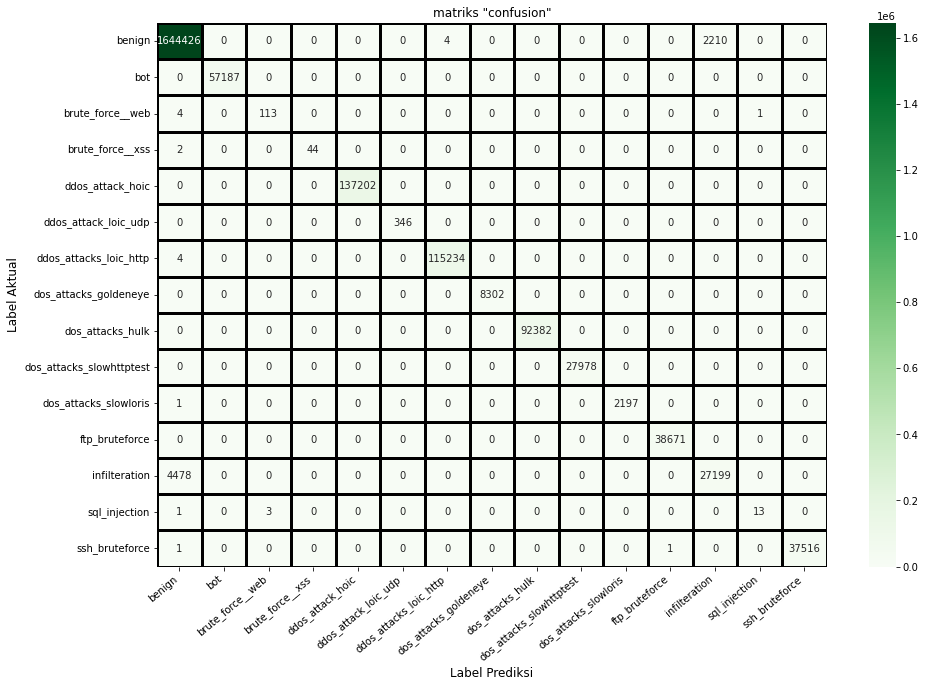

misklasifikasi kelas target:
                          misklasifikasi    total  \
sql_injection                          4       17   
infilteration                       4478    31677   
brute_force__xss                       2       46   
brute_force__web                       5      118   
benign                              2214  1646640   
dos_attacks_slowloris                  1     2198   
ssh_bruteforce                         2    37518   
ddos_attacks_loic_http                 4   115238   
bot                                    0    57187   
ddos_attack_hoic                       0   137202   
ddos_attack_loic_udp                   0      346   
dos_attacks_goldeneye                  0     8302   
dos_attacks_hulk                       0    92382   
dos_attacks_slowhttptest               0    27978   
ftp_bruteforce                         0    38671   

                          persentase_misklasifikasi(%)  
sql_injection                                23.529412  
infilter

In [22]:
# metrik evaluasi lapisan 3 berdasarkan f1
metrik (klf_f1, 2, y_aktual_multi, y_f1)

# misklasifikasi lapisan 3
misklasifikasi(y_aktual_multi, y_f1)